# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Exploratory analysis of cereals production in Italy 2006-2022
#### Author: Maria Fisher 


The main objective of this study is to have gather information about crop production in Italy for the period of 2006-2022. 

Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).



In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns 
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
cereals = pd.read_csv('./Italy_crop_data/cereals_legumes.csv',skipinitialspace=True)
cereals.head()

,ITTER107,Territory,TIPO_DATO5,Data type,AGRI_MADRE,Type of crop,TIME,Select time,Value,Flag Codes,Flags
0,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2006,2006,17100.00,NaN,NaN
1,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2007,2007,21502.00,NaN,NaN
2,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2008,2008,23400.00,NaN,NaN
3,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2009,2009,23167.00,e,estimate data
4,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2010,2010,20904.00,e,estimate data


## Pre-processing dataset 

In [3]:
# Drop Columns
cereals = cereals.drop(columns =['ITTER107','TIPO_DATO5','AGRI_MADRE', 'TIME', 'Flag Codes','Flags' ])
cereals

,Territory,Data type,Type of crop,Select time,Value
0,Torino,total area - hectares,common wheat,2006,17100.00
1,Torino,total area - hectares,common wheat,2007,21502.00
2,Torino,total area - hectares,common wheat,2008,23400.00
3,Torino,total area - hectares,common wheat,2009,23167.00
4,Torino,total area - hectares,common wheat,2010,20904.00
...,...,...,...,...,...
66260,Pesaro e Urbino,total area - hectares,rye and winter cereal mixtures (maslin),2022,3.00
66261,Roma,total area - hectares,rye and winter cereal mixtures (maslin),2022,20.00
66262,Valle d'Aosta / Vallée d'Aoste,total area - hectares,winter barley,2022,1.00
66263,Torino,total area - hectares,spring barley,2022,220.00


In [4]:
# Rename Columns
cereals = cereals.rename(columns = {'Select time':'Year', 'Type of crop':'Type_crop', 'Data type':'Data_type', 'Territory':'City'})


In [5]:
def show_info(cereals):
    print('DATASET SHAPE: ', cereals.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(cereals.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(cereals.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(cereals.isnull().sum())
show_info(cereals)

DATASET SHAPE:  (66265, 5) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66265 entries, 0 to 66264
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   City       66265 non-null  object 
 1   Data_type  66265 non-null  object 
 2   Type_crop  66265 non-null  object 
 3   Year       66265 non-null  int64  
 4   Value      66265 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 2.5+ MB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

City           112
Data_type        3
Type_crop       29
Year            17
Value        14104
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
City         0
Data_type    0
Type_crop    0
Year         0
Value        0
dtype: int64


## Cities in Italy producing cereals

In [6]:
cereals.City.unique()


array(['Torino', 'Vercelli', 'Biella', 'Verbano-Cusio-Ossola', 'Novara',
       'Cuneo', 'Asti', 'Alessandria', "Valle d'Aosta / Vallée d'Aoste",
       'Savona', 'Genova', 'La Spezia', 'Varese', 'Como', 'Lecco',
       'Sondrio', 'Milano', 'Bergamo', 'Brescia', 'Pavia', 'Lodi',
       'Cremona', 'Mantova', 'Trentino Alto Adige / Südtirol', 'Verona',
       'Vicenza', 'Belluno', 'Treviso', 'Venezia', 'Padova', 'Rovigo',
       'Pordenone', 'Udine', 'Gorizia', 'Trieste', 'Piacenza', 'Parma',
       "Reggio nell'Emilia", 'Modena', 'Bologna', 'Ferrara', 'Ravenna',
       'Forlì-Cesena', 'Rimini', 'Massa-Carrara', 'Lucca', 'Pistoia',
       'Firenze', 'Prato', 'Livorno', 'Pisa', 'Arezzo', 'Siena',
       'Grosseto', 'Perugia', 'Terni', 'Pesaro e Urbino', 'Ancona',
       'Macerata', 'Ascoli Piceno', 'Viterbo', 'Rieti', 'Roma', 'Latina',
       'Frosinone', "L'Aquila", 'Teramo', 'Pescara', 'Chieti', 'Isernia',
       'Campobasso', 'Caserta', 'Benevento', 'Avellino', 'Salerno',
       'Foggi

In [7]:
#cereals.Data_type.unique()

## Select only Values for total production - quintals
In general crop production is reported in tonnes per hectare , however Istat (http://dati.istat.it) does not give variables definition, so we have assumed that the column 'Value' for rows containing data for 'harvested production - quintals', are values for total production of cereals  = yield(in quintal/ha). 

In [8]:
cereals_total_prod = cereals[cereals['Data_type'] == 'total production - quintals ']
cereals_total_prod.head()

,City,Data_type,Type_crop,Year,Value
17,Torino,total production - quintals,common wheat,2006,1197000.00
18,Torino,total production - quintals,common wheat,2007,1333100.00
19,Torino,total production - quintals,common wheat,2008,1216800.00
20,Torino,total production - quintals,common wheat,2009,1149083.00
21,Torino,total production - quintals,common wheat,2010,1092994.00


In [9]:
cereals_total_prod = cereals_total_prod.rename(columns = {'Value':'Total_production'})
cereals_total_prod

,City,Data_type,Type_crop,Year,Total_production
17,Torino,total production - quintals,common wheat,2006,1197000.00
18,Torino,total production - quintals,common wheat,2007,1333100.00
19,Torino,total production - quintals,common wheat,2008,1216800.00
20,Torino,total production - quintals,common wheat,2009,1149083.00
21,Torino,total production - quintals,common wheat,2010,1092994.00
...,...,...,...,...,...
66193,Trentino Alto Adige / Südtirol,total production - quintals,winter barley,2022,200.00
66198,Trentino Alto Adige / Südtirol,total production - quintals,spring barley,2021,1890.00
66199,Trentino Alto Adige / Südtirol,total production - quintals,spring barley,2022,1700.00
66204,Trentino Alto Adige / Südtirol,total production - quintals,oats and spring cereal mixtures (mixed grain o...,2021,372.00


In [10]:
cereals_total_prod =cereals_total_prod.drop(columns =['Data_type' ])
cereals_total_prod

,City,Type_crop,Year,Total_production
17,Torino,common wheat,2006,1197000.00
18,Torino,common wheat,2007,1333100.00
19,Torino,common wheat,2008,1216800.00
20,Torino,common wheat,2009,1149083.00
21,Torino,common wheat,2010,1092994.00
...,...,...,...,...
66193,Trentino Alto Adige / Südtirol,winter barley,2022,200.00
66198,Trentino Alto Adige / Südtirol,spring barley,2021,1890.00
66199,Trentino Alto Adige / Südtirol,spring barley,2022,1700.00
66204,Trentino Alto Adige / Südtirol,oats and spring cereal mixtures (mixed grain o...,2021,372.00


## Total cereal production in 2006-2022

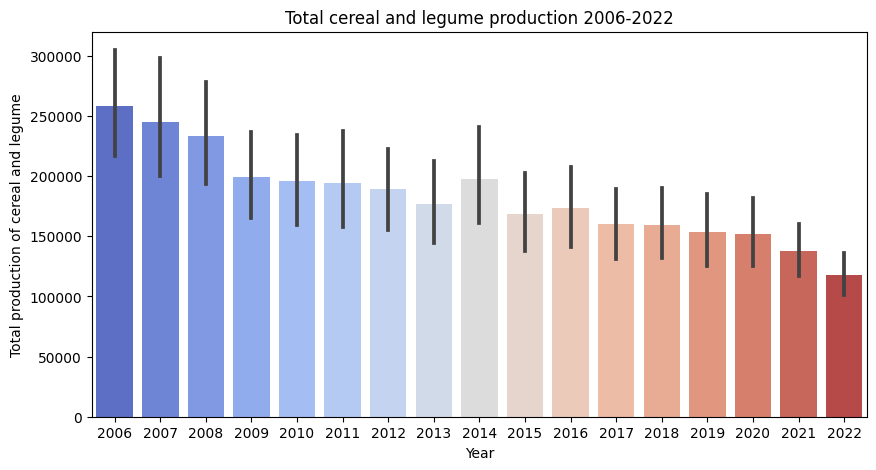

In [18]:
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'Total_production',data = cereals_total_prod,palette='coolwarm')
plt.title('Total cereal and legume production 2006-2022')
plt.xlabel('Year')
plt.ylabel('Total production of cereal and legume')
plt.show()



## Cereal production by Cities 

In [12]:
cereals_total_prod_region = cereals_total_prod.groupby(by = cereals_total_prod.City)['Total_production','City'].sum().reset_index().sort_values(by = 'Total_production', ascending = False).head(10)
cereals_total_prod_region

,City,Total_production
32,Ferrara,202706622.00
13,Bologna,187911233.00
34,Foggia,160763133.00
85,Rovigo,148035128.00
65,Padova,143780892.00
68,Pavia,139829089.00
51,Mantova,135574069.00
105,Venezia,133664692.00
96,Torino,131212960.00
29,Cuneo,103723577.00


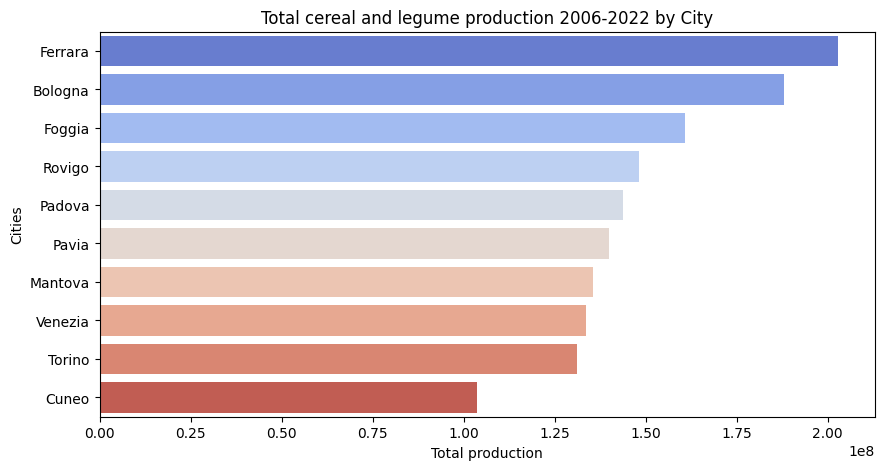

In [19]:
plt.figure(figsize= (10,5))
sns.barplot(x=cereals_total_prod_region['Total_production'],y= cereals_total_prod_region['City'], orient='h', palette='coolwarm');
plt.title('Total cereal and legume production 2006-2022 by City')
plt.xlabel('Total production')
plt.ylabel('Cities')
plt.show()

## Italy geographic areas is organized in regions, provinces or comunes. 
### The regions are classified as follow:


#### Sud/Mezzogiorno:  

Abruzzo, Apulia/Puglia, Basilicata, Calabria, Campania, Molise, Sicily 

* Abruzzo: L'Aquila, Pescara, Chieti, Teramo

* Apulia/Puglia: Foggia, Bari, Taranto, Brindisi, Lecce, Barletta-Andria-Trani

* Basilicata: Matera, Potenza

* Calabria: Crotone, Vibo, Valentia, Cosenza, Catanzaro, Reggio di Calabria

* Campania: Benevento, Caserta, Napoli, Avellino, Salerno

* Molise: Campobasso, Isernia

* Sicilia: Messina,Siracusa, Agrigento, Caltanissetta, Trapani, Enna, Palermo, Catania, Ragusa

* Sardegna: Oristano, Carbonia-Iglesias, Olbia-Tempio, Ogliastr, Medio Campidano, Sassari, Nuoro, Cagliari



#### Centro: 

Toscana, Umbria, Marche, Lazio

* Toscana: Pistoia, Firenze, Massa-Carrara, Lucca, Arezzo, Livorno, Pisa, Grosseto, Siena, Prato

* Umbria: Perugia, Terni   

* Marche: Ancona, Macerata, Ascoli Piceno, Pesaro e Urbino, Fermo

* Lazio:  Roma, Viterbo, Rieti, Latina, Frosinone


#### Nord-ovest: 

Piemonte, Valle d’Aosta, Lombardia, Liguria

* Liguria: Imperia, Savona, Genova, La Spezia

* Lombardia: Como, Varese, Milano, Pavia, Bergamo, Brescia, Sondrio, Cremona, Mantova, Monza e Della Brianza, Lecco,Lodi

* Piemonte: Vercelli, Novara, Torino, Cuneo, Asti, Alessandria, Biella, Verbano-Cusio-Ossola

* Valdaosta:  Valle d'Aosta


#### Nord-est:

Trentino-Alto Adige, Veneto, Fiuli-Venezia Giulia, Emilia-Romagna


* Trentino: Bolzano/Bozen, Trento

* Veneto:  Belluno, Verona, Vicenza, Rovigo, Treviso, Venezia, Padova

* Friuli: Udine, Gorizia, Trieste, Pordenone

* Emilia-Romagna: Parma, Reggio Nell'Emilia, Piacenza, Forli'-Cesena, Modena, Bologna, Ferrara, Ravenna, Rimini











## Cereals highest production 2006-2022

In [14]:
print(cereals_total_prod.Type_crop.max())
print(cereals_total_prod.Type_crop.value_counts())
print(cereals_total_prod.Type_crop.nunique())



winter cereal mixtures (maslin)
potatoes                                                           1786
barley                                                             1733
grain maize                                                        1671
oats                                                               1650
common wheat                                                       1583
durum wheat                                                        1579
sorghum                                                            1246
dried kidney bean                                                  1239
broad bean                                                         1158
other cereals                                                      1148
chick-peas                                                         1088
protein pea                                                         949
rye                                                                 900
grain pea                       

Dataset shows there are 29 different types of cereals cultivated in Italy. Ten crop produced are Common wheat, Durum wheat, Potatoes, Barley, Maize, Beans, Chick-peas, Rye, Rice and Oats. 

In [15]:
cereals_total_prod.describe().astype(int)

,Year,Total_production
count,22079,22079
mean,2014,179401
std,4,624049
min,2006,0
25%,2010,1020
50%,2015,8568
75%,2019,72105
max,2022,10164000


In [16]:
# Rename name of crops 
cereals_total_prod = cereals_total_prod.replace('oats and spring cereal mixtures (mixed grain other than maslin)','oats mix')
cereals_total_prod = cereals_total_prod.replace('rye and winter cereal mixtures (maslin)','rye mix')
cereals_total_prod = cereals_total_prod.replace('spring cereal mixtures (mixed grain other than maslin)','cereal mix')
cereals_total_prod = cereals_total_prod.replace('common spring wheat and spelt','c-spr-wheat&spelt')
cereals_total_prod = cereals_total_prod.replace('common winter wheat and spelt','c-wint-wheat&spelt')
cereals_total_prod = cereals_total_prod.replace('winter cereal mixtures (maslin)','wint-cereal-mix')
cereals_total_prod = cereals_total_prod.replace('dried kidney bean','dry-k-bean')
cereals_total_prod = cereals_total_prod.replace('common wheat','c-wheat')
cereals_total_prod = cereals_total_prod.replace('durum wheat','d-wheat')
cereals_total_prod = cereals_total_prod.replace('broad bean','bro-bean')
cereals_total_prod = cereals_total_prod.replace('grain maize','maize')



 

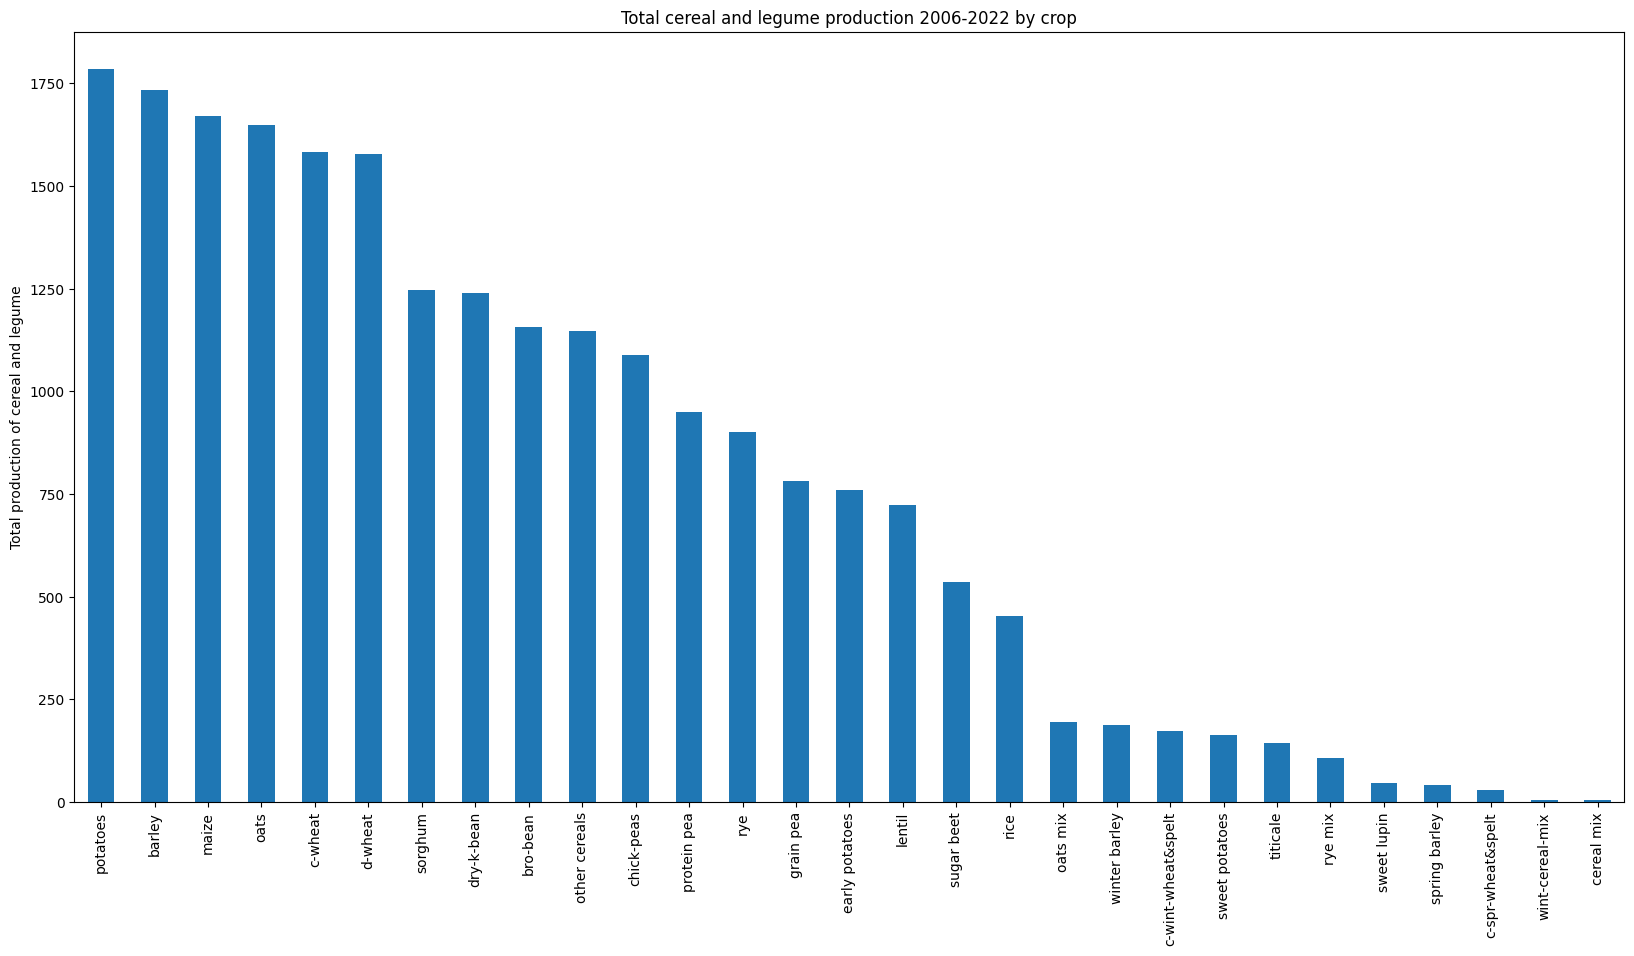

In [20]:
plt.figure(figsize=(20,10))
cereals_total_prod ['Type_crop'].value_counts().plot.bar()
plt.title('Total cereal and legume production 2006-2022 by crop')
plt.ylabel('Total production of cereal and legume')
plt.show()


## Subseting data

In [21]:
cereals_top10 = cereals_total_prod.apply(lambda row: row[cereals_total_prod['Type_crop'].isin(['barley','oats', 
                                         'd-wheat','c-wheat', 'maize', 'potatoes','dry-k-bean',
                                          'bro-bean','chick-peas','rye'])])

cereals_top10.head()

,City,Type_crop,Year,Total_production
17,Torino,c-wheat,2006,1197000.00
18,Torino,c-wheat,2007,1333100.00
19,Torino,c-wheat,2008,1216800.00
20,Torino,c-wheat,2009,1149083.00
21,Torino,c-wheat,2010,1092994.00


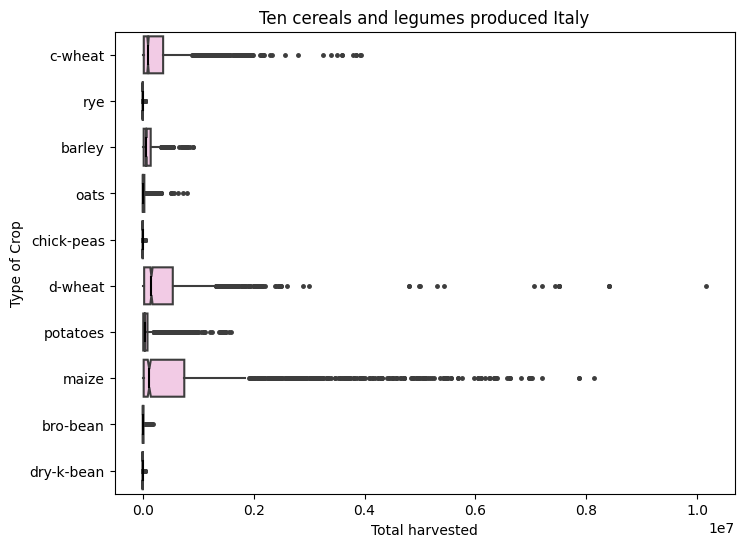

In [22]:
plt.figure(figsize=(8,6))

sns.boxplot(
    data=cereals_top10, y="Type_crop", x="Total_production",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.9, .6, .8, .5)},
    medianprops={"color": "black"},
)

plt.title('Ten cereals and legumes produced Italy')
plt.ylabel('Type of Crop')
plt.xlabel('Total harvested')
plt.show()

## Vizualization of ten type of cereals and legumes produced in Italy in the period of 2006-2022 

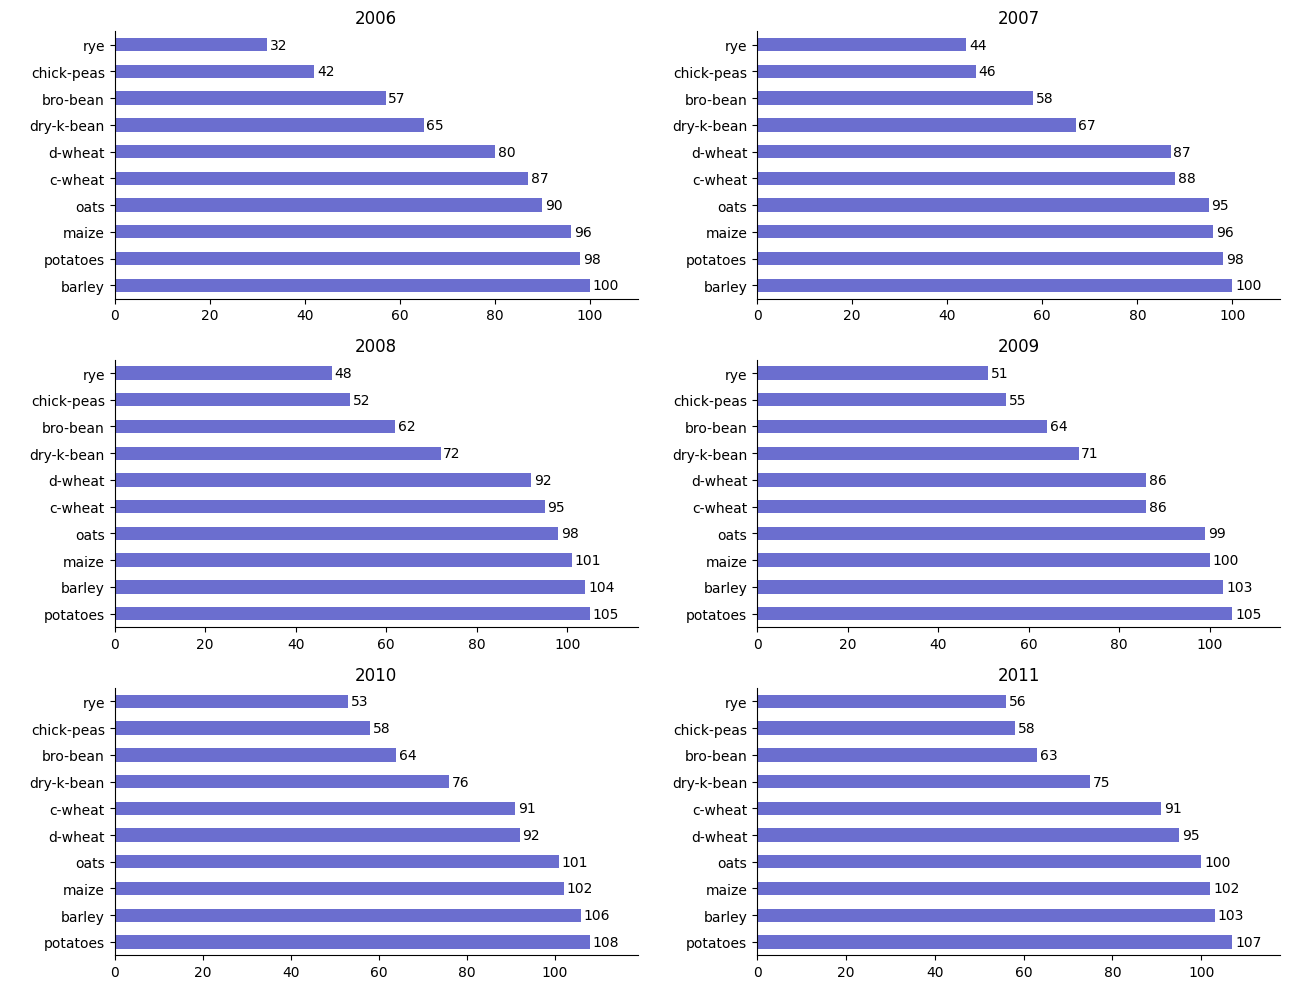

In [23]:
fig, axs = plt.subplots(3,2, figsize=(13, 10))
plt.ylabel(" ")

plot1 = cereals_top10[cereals_top10.Year == 2006].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2006', ax=axs[0,0])
plot2 = cereals_top10[cereals_top10.Year == 2007].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2007', ax=axs[0,1])
plot3 = cereals_top10[cereals_top10.Year == 2008].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2008', ax=axs[1,0])
plot4 = cereals_top10[cereals_top10.Year == 2009].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2009', ax=axs[1,1])
plot5 = cereals_top10[cereals_top10.Year == 2010].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2010', ax=axs[2,0])
plot6 = cereals_top10[cereals_top10.Year == 2011].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2011', ax=axs[2,1])

for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
    ax.set_ylabel(' ')
    sns.despine()

plt.tight_layout()
plt.show()

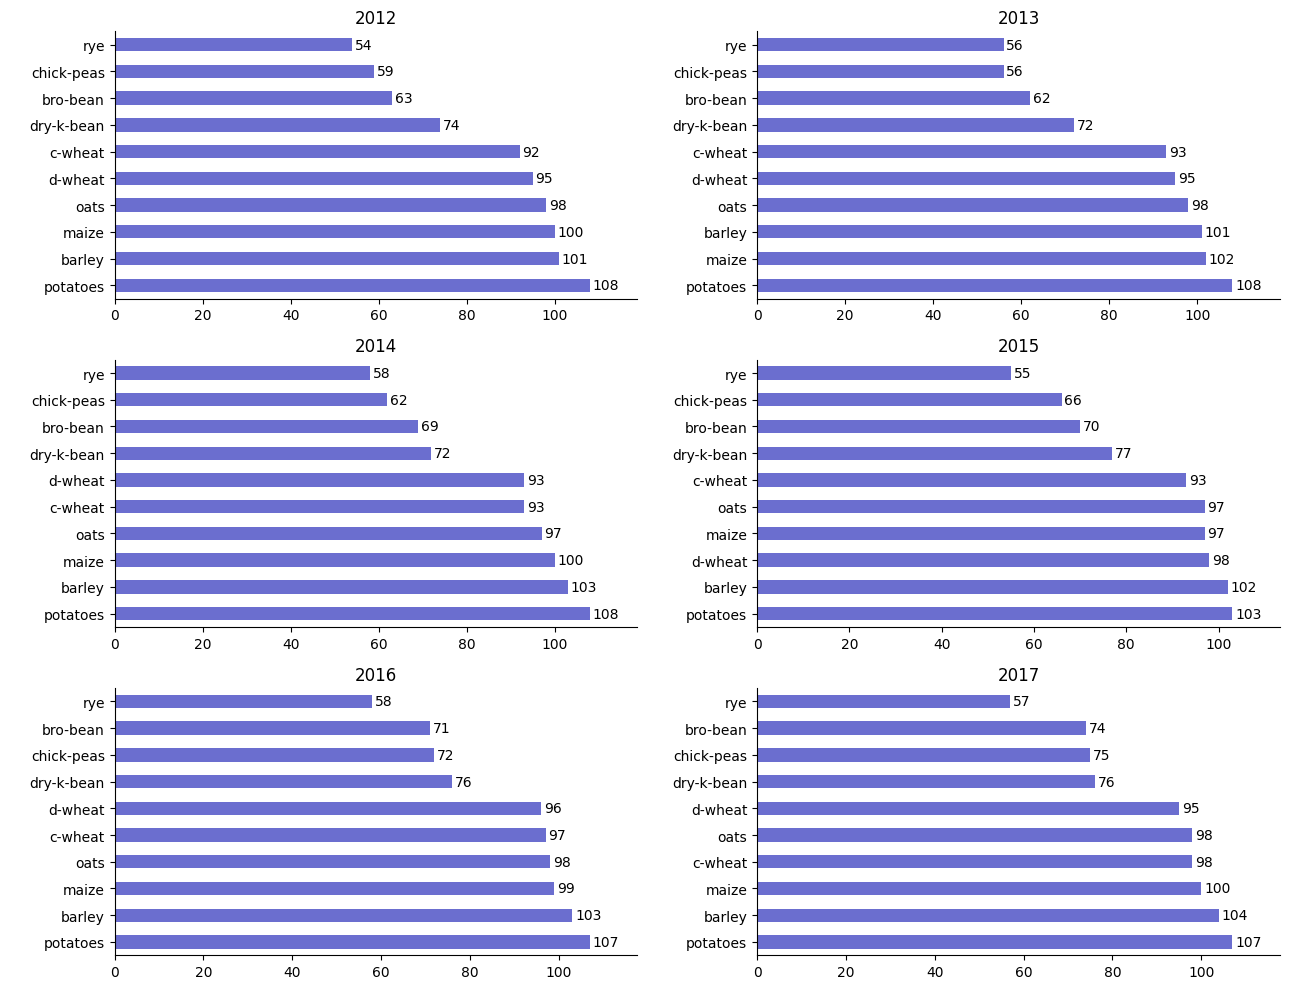

In [25]:
fig, axs = plt.subplots(3,2, figsize=(13, 10))


plot7 = cereals_top10[cereals_top10.Year == 2012].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2012', ax=axs[0,0])
plot8 = cereals_top10[cereals_top10.Year == 2013].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2013', ax=axs[0,1])
plot9 = cereals_top10[cereals_top10.Year == 2014].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2014', ax=axs[1,0])
plot10 = cereals_top10[cereals_top10.Year == 2015].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2015', ax=axs[1,1])
plot11 = cereals_top10[cereals_top10.Year == 2016].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2016', ax=axs[2,0])
plot12 = cereals_top10[cereals_top10.Year == 2017].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2017', ax=axs[2,1])

for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
    ax.set_ylabel(' ')
    sns.despine()
    
plt.tight_layout()
plt.show()

IndexError: list index out of range

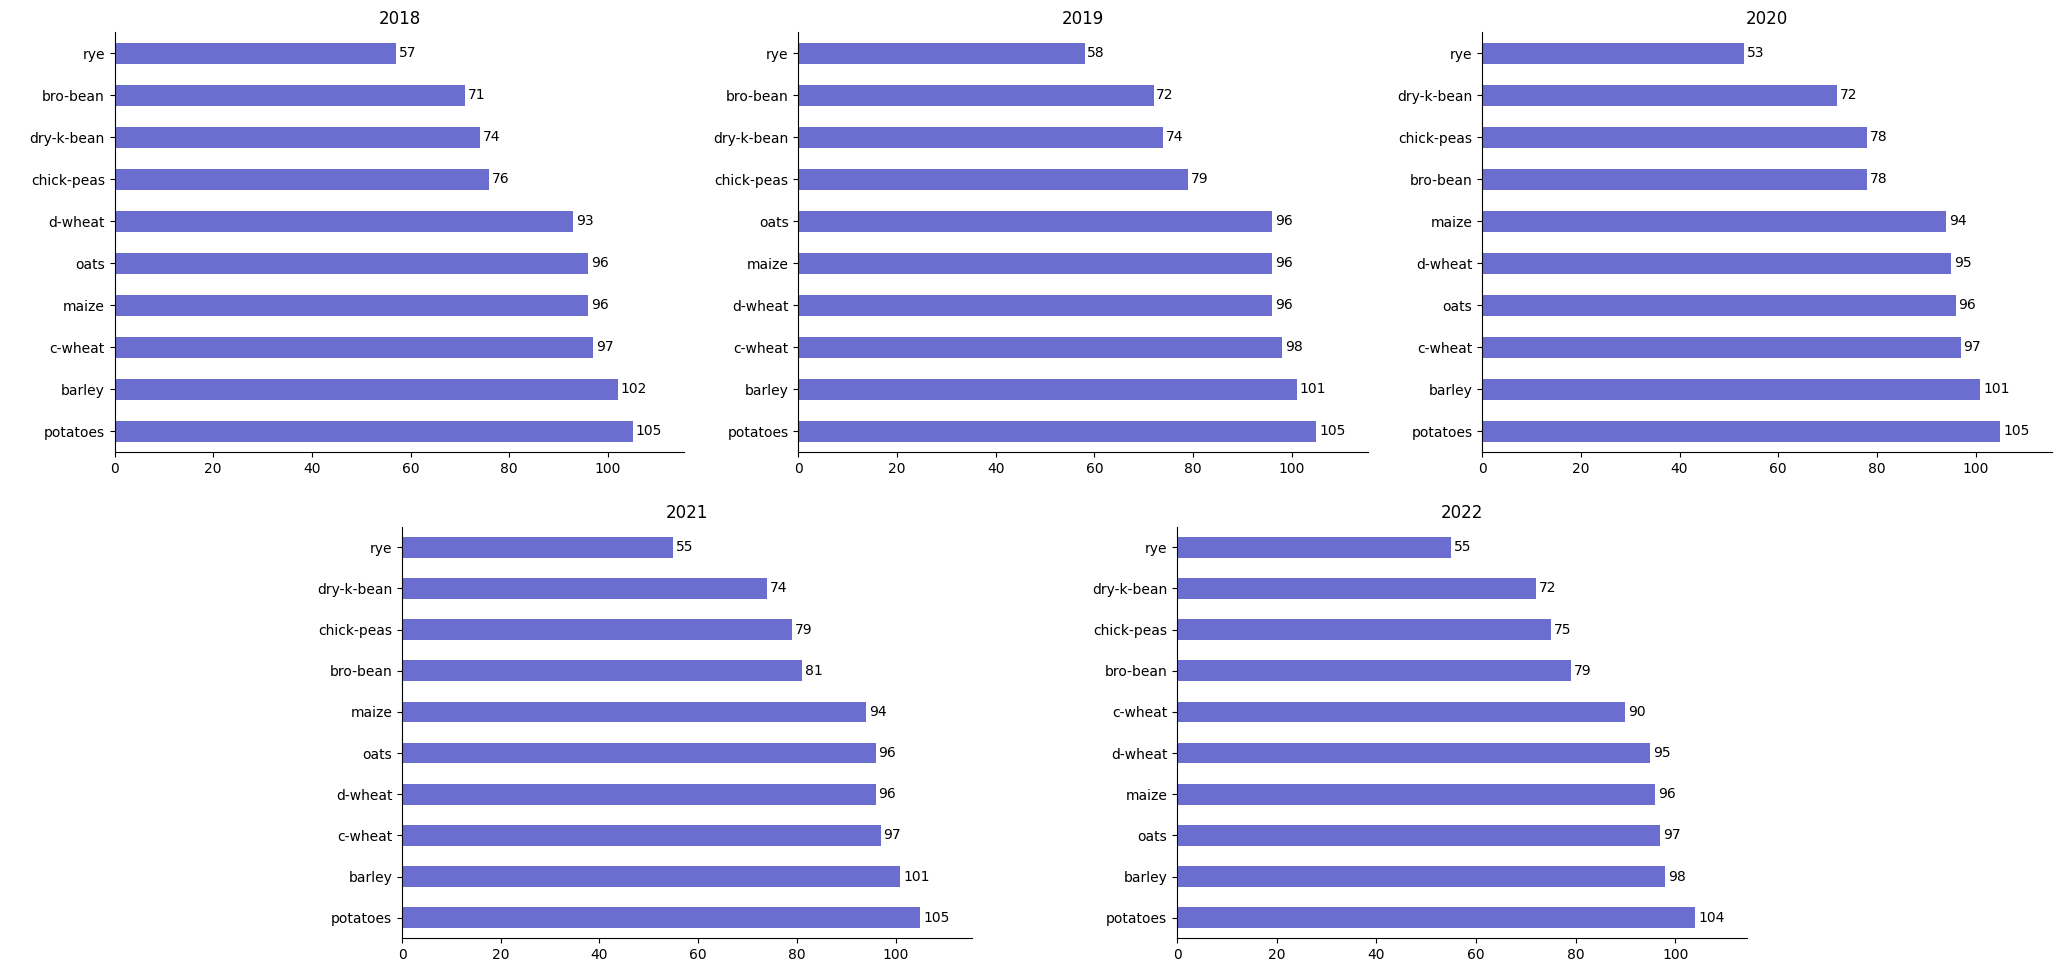

In [24]:

fig, axs = plt.subplots(2,3, figsize=(25,12))

axs[1,0].set_position([0.24,0.125,0.228,0.343])
axs[1,1].set_position([0.55,0.125,0.228,0.343])
axs[1,2].set_visible(False)

plot13 = cereals_top10[cereals_top10.Year == 2018].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2018', ax=axs[0,0])
plot14 = cereals_top10[cereals_top10.Year == 2019].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2019', ax=axs[0,1])
plot15 = cereals_top10[cereals_top10.Year == 2020].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2020', ax=axs[0,2])
plot16 = cereals_top10[cereals_top10.Year == 2021].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2021', ax=axs[1,0])
plot17 = cereals_top10[cereals_top10.Year == 2022].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2022', ax=axs[1,1])

for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
    ax.set_ylabel(' ')
    sns.despine()

plt.tight_layout()

plt.show()



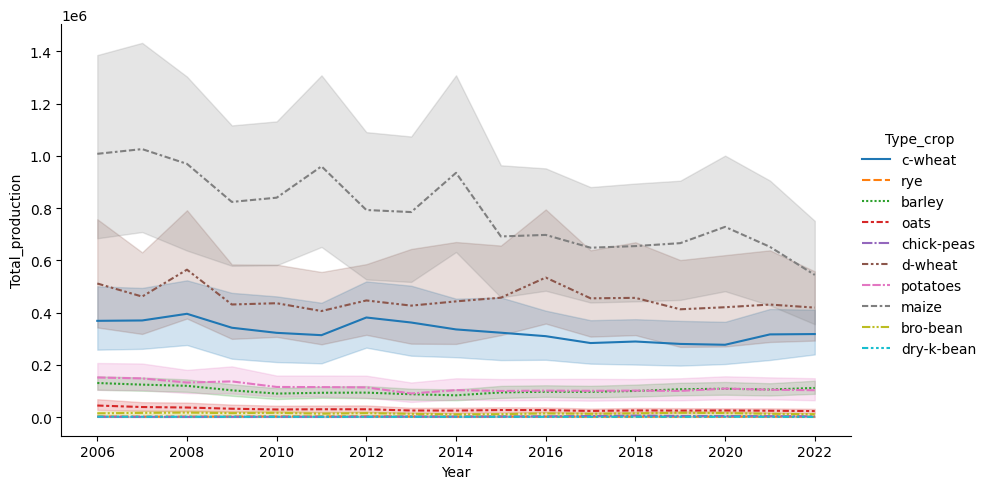

In [26]:
#Crop harvested by year
plotcrop10 = sns.relplot(kind='line', data=cereals_top10, x='Year', y='Total_production', hue='Type_crop', style='Type_crop', aspect=1.75)


In [27]:
# Create columns for each type of fertilizer 
cereals_top10_pivot = cereals_top10.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_crop',values=['Total_production'])
cereals_top10_pivot




Total_production                                           \
Type_crop                barley bro-bean   c-wheat chick-peas    d-wheat   
City      Year                                                             
Agrigento 2006          8970.00 70490.00       NaN    1500.00 1102000.00   
          2007          8400.00 66774.00       NaN    1395.00 1180000.00   
          2008          9250.00 74400.00       NaN    1207.00 1218000.00   
          2009         10400.00 70400.00       NaN    1233.00  953846.00   
          2010         11870.00 71230.00       NaN    1280.00 1347000.00   
...                         ...      ...       ...        ...        ...   
Viterbo   2018        430000.00      NaN 117600.00   11200.00  768000.00   
          2019        510000.00      NaN 140000.00   10500.00  800000.00   
          2020        555000.00      NaN 136000.00   10100.00  749000.00   
          2021        540000.00      NaN 129000.00    9850.00  740000.00   
          2022        520000.00      NaN 125000.00    9800.00  730000.00   

                                                                
Type_crop      dry-k-bean     maize     oats  potatoes     rye  
City      Year                                                  
Agrigento 2006     800.00       NaN  7260.00  50750.00     NaN  
          2007     671.00       NaN  7537.00  47873.00     NaN  
          2008     630.00       NaN  8160.00  56240.00     NaN  
          2009     650.00       NaN  9460.00  58100.00     NaN  
          2010     705.00       NaN 10700.00  85600.00     NaN  
...                   ...       ...      ...       ...     ...  
Viterbo   2018     660.00 198000.00 26500.00 460000.00 5040.00  
          2019     600.00 180000.00 33600.00 345700.00 5600.00  
          2020     590.00 178000.00 31100.00 420000.00 5100.00  
          2021     340.00 172500.00 30100.00 450000.00 4790.00  
          2022     330.00 171000.00 29000.00 450000.00 4690.00  

[1849 rows x 10 columns]

In [28]:

# Drop level
cereals_top10_pivot.columns = cereals_top10_pivot.columns.droplevel()
cereals_top10_pivot



Type_crop         barley  bro-bean   c-wheat  chick-peas    d-wheat  \
City      Year                                                        
Agrigento 2006   8970.00  70490.00       NaN     1500.00 1102000.00   
          2007   8400.00  66774.00       NaN     1395.00 1180000.00   
          2008   9250.00  74400.00       NaN     1207.00 1218000.00   
          2009  10400.00  70400.00       NaN     1233.00  953846.00   
          2010  11870.00  71230.00       NaN     1280.00 1347000.00   
...                  ...       ...       ...         ...        ...   
Viterbo   2018 430000.00       NaN 117600.00    11200.00  768000.00   
          2019 510000.00       NaN 140000.00    10500.00  800000.00   
          2020 555000.00       NaN 136000.00    10100.00  749000.00   
          2021 540000.00       NaN 129000.00     9850.00  740000.00   
          2022 520000.00       NaN 125000.00     9800.00  730000.00   

Type_crop       dry-k-bean     maize     oats  potatoes     rye  
City      Year                                                   
Agrigento 2006      800.00       NaN  7260.00  50750.00     NaN  
          2007      671.00       NaN  7537.00  47873.00     NaN  
          2008      630.00       NaN  8160.00  56240.00     NaN  
          2009      650.00       NaN  9460.00  58100.00     NaN  
          2010      705.00       NaN 10700.00  85600.00     NaN  
...                    ...       ...      ...       ...     ...  
Viterbo   2018      660.00 198000.00 26500.00 460000.00 5040.00  
          2019      600.00 180000.00 33600.00 345700.00 5600.00  
          2020      590.00 178000.00 31100.00 420000.00 5100.00  
          2021      340.00 172500.00 30100.00 450000.00 4790.00  
          2022      330.00 171000.00 29000.00 450000.00 4690.00  

[1849 rows x 10 columns]

In [29]:
cereals_top10_pivot = cereals_top10_pivot.fillna(0)
cereals_top10_pivot



Type_crop         barley  bro-bean   c-wheat  chick-peas    d-wheat  \
City      Year                                                        
Agrigento 2006   8970.00  70490.00      0.00     1500.00 1102000.00   
          2007   8400.00  66774.00      0.00     1395.00 1180000.00   
          2008   9250.00  74400.00      0.00     1207.00 1218000.00   
          2009  10400.00  70400.00      0.00     1233.00  953846.00   
          2010  11870.00  71230.00      0.00     1280.00 1347000.00   
...                  ...       ...       ...         ...        ...   
Viterbo   2018 430000.00      0.00 117600.00    11200.00  768000.00   
          2019 510000.00      0.00 140000.00    10500.00  800000.00   
          2020 555000.00      0.00 136000.00    10100.00  749000.00   
          2021 540000.00      0.00 129000.00     9850.00  740000.00   
          2022 520000.00      0.00 125000.00     9800.00  730000.00   

Type_crop       dry-k-bean     maize     oats  potatoes     rye  
City      Year                                                   
Agrigento 2006      800.00      0.00  7260.00  50750.00    0.00  
          2007      671.00      0.00  7537.00  47873.00    0.00  
          2008      630.00      0.00  8160.00  56240.00    0.00  
          2009      650.00      0.00  9460.00  58100.00    0.00  
          2010      705.00      0.00 10700.00  85600.00    0.00  
...                    ...       ...      ...       ...     ...  
Viterbo   2018      660.00 198000.00 26500.00 460000.00 5040.00  
          2019      600.00 180000.00 33600.00 345700.00 5600.00  
          2020      590.00 178000.00 31100.00 420000.00 5100.00  
          2021      340.00 172500.00 30100.00 450000.00 4790.00  
          2022      330.00 171000.00 29000.00 450000.00 4690.00  

[1849 rows x 10 columns]

In [30]:
#Rename index
cereals_top10_pivot = cereals_top10_pivot.rename_axis(None,axis=1)
cereals_top10_pivot



barley  bro-bean   c-wheat  chick-peas    d-wheat  \
City      Year                                                        
Agrigento 2006   8970.00  70490.00      0.00     1500.00 1102000.00   
          2007   8400.00  66774.00      0.00     1395.00 1180000.00   
          2008   9250.00  74400.00      0.00     1207.00 1218000.00   
          2009  10400.00  70400.00      0.00     1233.00  953846.00   
          2010  11870.00  71230.00      0.00     1280.00 1347000.00   
...                  ...       ...       ...         ...        ...   
Viterbo   2018 430000.00      0.00 117600.00    11200.00  768000.00   
          2019 510000.00      0.00 140000.00    10500.00  800000.00   
          2020 555000.00      0.00 136000.00    10100.00  749000.00   
          2021 540000.00      0.00 129000.00     9850.00  740000.00   
          2022 520000.00      0.00 125000.00     9800.00  730000.00   

                dry-k-bean     maize     oats  potatoes     rye  
City      Year                                                   
Agrigento 2006      800.00      0.00  7260.00  50750.00    0.00  
          2007      671.00      0.00  7537.00  47873.00    0.00  
          2008      630.00      0.00  8160.00  56240.00    0.00  
          2009      650.00      0.00  9460.00  58100.00    0.00  
          2010      705.00      0.00 10700.00  85600.00    0.00  
...                    ...       ...      ...       ...     ...  
Viterbo   2018      660.00 198000.00 26500.00 460000.00 5040.00  
          2019      600.00 180000.00 33600.00 345700.00 5600.00  
          2020      590.00 178000.00 31100.00 420000.00 5100.00  
          2021      340.00 172500.00 30100.00 450000.00 4790.00  
          2022      330.00 171000.00 29000.00 450000.00 4690.00  

[1849 rows x 10 columns]

In [31]:
# Reset index
cereals_top10_pivot = cereals_top10_pivot.reset_index()
cereals_top10_pivot

,City,Year,barley,bro-bean,c-wheat,chick-peas,d-wheat,dry-k-bean,maize,oats,potatoes,rye
0,Agrigento,2006,8970.00,70490.00,0.00,1500.00,1102000.00,800.00,0.00,7260.00,50750.00,0.00
1,Agrigento,2007,8400.00,66774.00,0.00,1395.00,1180000.00,671.00,0.00,7537.00,47873.00,0.00
2,Agrigento,2008,9250.00,74400.00,0.00,1207.00,1218000.00,630.00,0.00,8160.00,56240.00,0.00
3,Agrigento,2009,10400.00,70400.00,0.00,1233.00,953846.00,650.00,0.00,9460.00,58100.00,0.00
4,Agrigento,2010,11870.00,71230.00,0.00,1280.00,1347000.00,705.00,0.00,10700.00,85600.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1844,Viterbo,2018,430000.00,0.00,117600.00,11200.00,768000.00,660.00,198000.00,26500.00,460000.00,5040.00
1845,Viterbo,2019,510000.00,0.00,140000.00,10500.00,800000.00,600.00,180000.00,33600.00,345700.00,5600.00
1846,Viterbo,2020,555000.00,0.00,136000.00,10100.00,749000.00,590.00,178000.00,31100.00,420000.00,5100.00
1847,Viterbo,2021,540000.00,0.00,129000.00,9850.00,740000.00,340.00,172500.00,30100.00,450000.00,4790.00


## Estatistical analysis

In [ ]:
cereals_top10_pivot.describe()

#### Data metrics : skew, kurtosis and mode

In [32]:
cereals_top10_pivot_stats = cereals_top10_pivot[['barley','bro-bean','c-wheat','chick-peas','d-wheat','dry-k-bean','maize','oats','potatoes','rye']]
print(cereals_top10_pivot_stats.astype(float).skew())
print(cereals_top10_pivot_stats.astype(float).kurtosis())
print(cereals_top10_pivot_stats.astype(float).mode())


barley       2.57
bro-bean     3.81
c-wheat      3.04
chick-peas   4.94
d-wheat      5.93
dry-k-bean   7.57
maize        2.51
oats         5.51
potatoes     3.80
rye          7.96
dtype: float64
barley        9.61
bro-bean     16.68
c-wheat      12.43
chick-peas   29.85
d-wheat      49.01
dry-k-bean   73.63
maize         6.08
oats         46.59
potatoes     16.35
rye          73.71
dtype: float64
   barley  bro-bean  c-wheat  chick-peas  d-wheat  dry-k-bean  maize  oats  \
0    0.00      0.00     0.00        0.00     0.00        0.00   0.00  0.00   

   potatoes  rye  
0      0.00 0.00  


### Graphs
#### Histogram and Boxplot showing data distribuion and outliers¶


### Normalizing the dataset

The data need to be normalized for further use in a modelling. Here the data will be normalize by deleting outliers using the interquartile range (IQR).


#### Calculate and print the interquartile range

In [33]:

Q1 = cereals_top10_pivot_stats.quantile(0.25)
Q3 = cereals_top10_pivot_stats.quantile(0.75)
IQR = Q3 - Q1
print(IQR)


barley       126100.00
bro-bean       7140.00
c-wheat      253560.00
chick-peas      950.00
d-wheat      446935.00
dry-k-bean      900.00
maize        551950.00
oats          24448.00
potatoes      74650.00
rye             756.00
dtype: float64


#### Remove outliers and plot graphs

In [34]:
# Remove outliers
cereals_top10_pivot_stats[~((cereals_top10_pivot < (Q1 - 1.5 * IQR)) | (cereals_top10_pivot_stats > (Q3 + 1.5 * IQR))).any(axis=1)]
print(cereals_top10_pivot.shape)

(1849, 12)


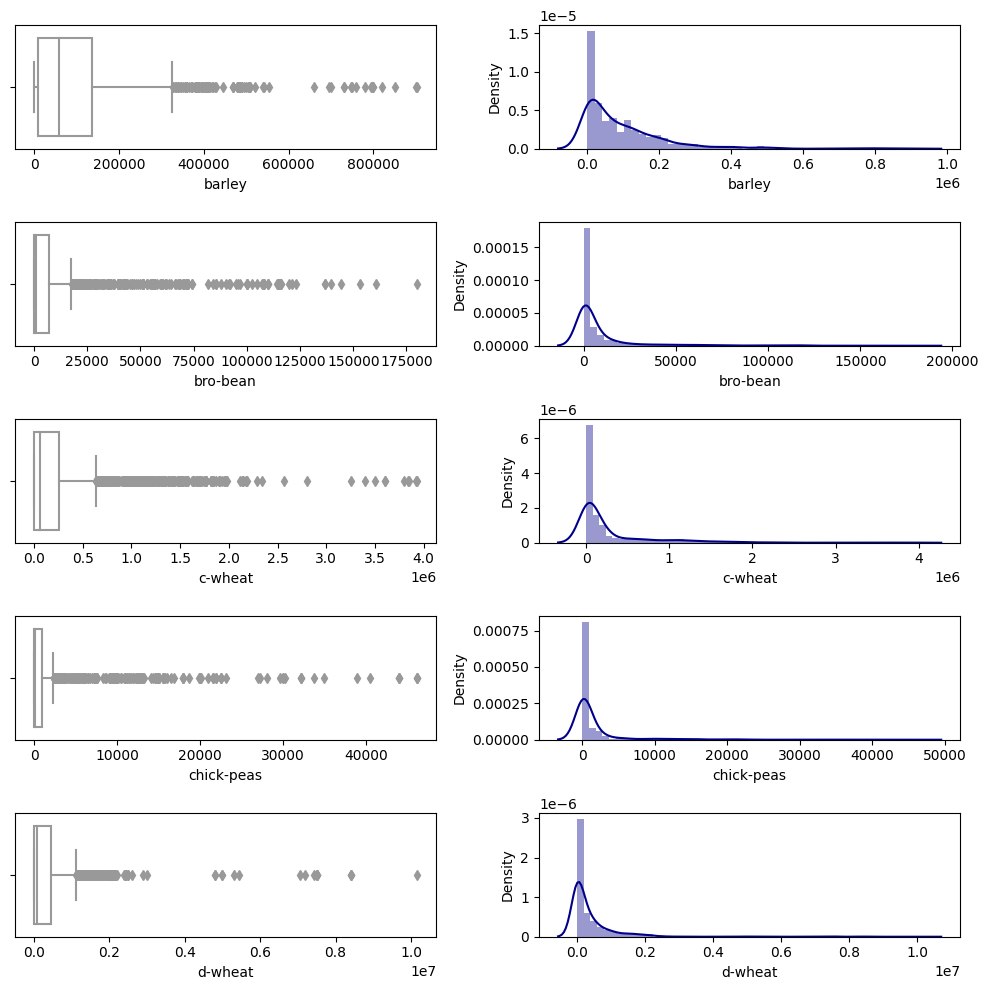

In [35]:
fig, ax = plt.subplots(5, 2, figsize = (10, 10))
sns.boxplot(x= cereals_top10_pivot_stats["barley"], color = 'white', ax = ax[0,0])
sns.distplot(cereals_top10_pivot_stats['barley'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= cereals_top10_pivot_stats["bro-bean"],color = 'white', ax = ax[1,0])
sns.distplot(cereals_top10_pivot_stats['bro-bean'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= cereals_top10_pivot_stats["c-wheat"],color = 'white', ax = ax[2,0])
sns.distplot(cereals_top10_pivot_stats['c-wheat'], color = 'darkblue',ax = ax[2,1])
sns.boxplot(x= cereals_top10_pivot_stats["chick-peas"], color = 'white', ax = ax[3,0])
sns.distplot(cereals_top10_pivot_stats['chick-peas'], color = 'darkblue', ax = ax[3,1])
sns.boxplot(x= cereals_top10_pivot_stats["d-wheat"], color = 'white',ax = ax[4,0])
sns.distplot(cereals_top10_pivot_stats['d-wheat'], color = 'darkblue',ax = ax[4,1])

plt.tight_layout()

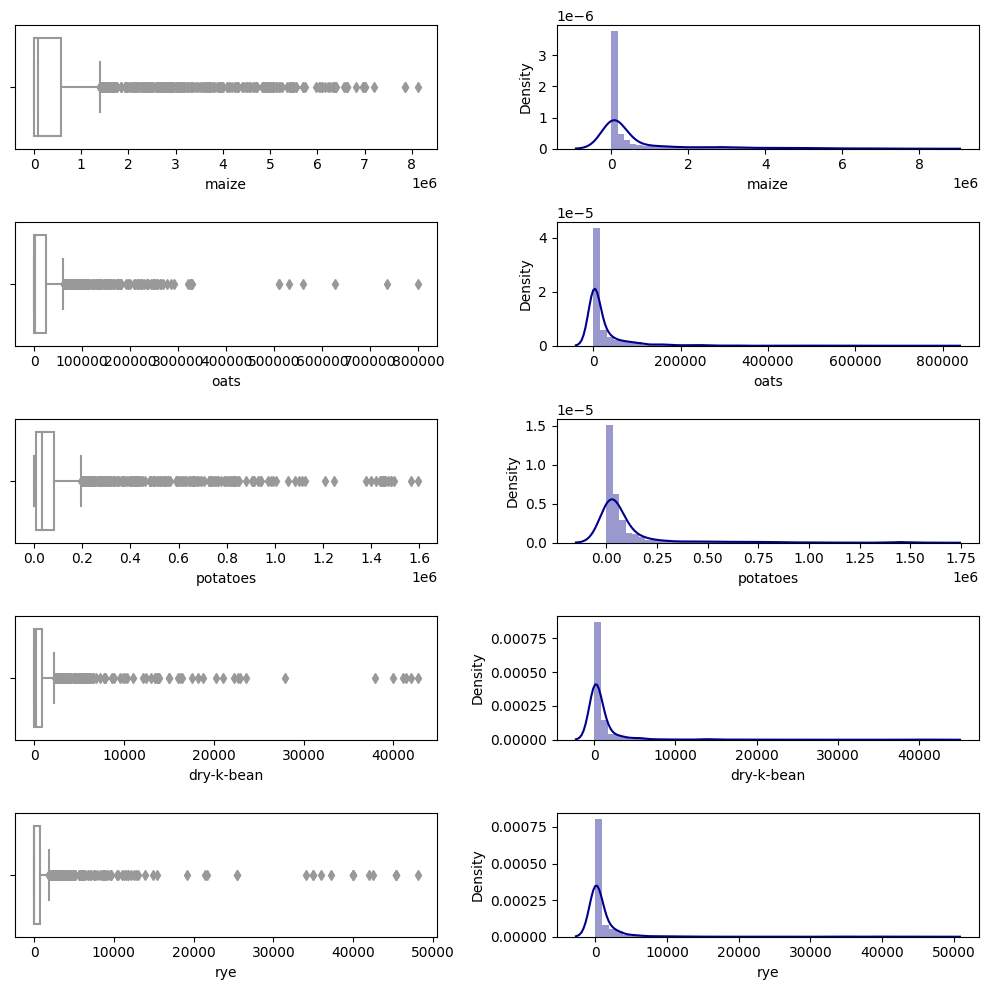

In [36]:
fig, ax = plt.subplots(5, 2, figsize = (10, 10))
sns.boxplot(x= cereals_top10_pivot_stats["maize"], color = 'white', ax = ax[0,0])
sns.distplot(cereals_top10_pivot_stats['maize'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= cereals_top10_pivot_stats["oats"],color = 'white', ax = ax[1,0])
sns.distplot(cereals_top10_pivot_stats['oats'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= cereals_top10_pivot_stats["potatoes"],color = 'white', ax = ax[2,0])
sns.distplot(cereals_top10_pivot_stats['potatoes'], color = 'darkblue',ax = ax[2,1])
sns.boxplot(x= cereals_top10_pivot_stats["dry-k-bean"], color = 'white',ax = ax[3,0])
sns.distplot(cereals_top10_pivot_stats['dry-k-bean'], color = 'darkblue',ax = ax[3,1])
sns.boxplot(x= cereals_top10_pivot_stats["rye"], color = 'white',ax = ax[4,0])
sns.distplot(cereals_top10_pivot_stats['rye'], color = 'darkblue',ax = ax[4,1])

plt.tight_layout()

In [ ]:
cereals_top10_pivot

### Pre-processing ferlizers dataset
fertilizers distributed - tonnes

In [37]:
fertilizer = pd.read_csv('fertilizer_by_prov.csv',skipinitialspace=True)
fertilizer.head()

,ITTER107,Territory,TIPO_DATO5,Data type,FERTILIZZANTI,Type of fertilizer,TIME,Select time,Value,Flag Codes,Flags
0,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2006,2006,1227,NaN,NaN
1,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2007,2007,1812,NaN,NaN
2,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2008,2008,5224,NaN,NaN
3,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2009,2009,2051,NaN,NaN
4,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2010,2010,54,NaN,NaN


In [38]:
fertilizer = fertilizer.drop(columns =['ITTER107','TIPO_DATO5', 'TIME','FERTILIZZANTI','Flag Codes','Flags'])
fertilizer

,Territory,Data type,Type of fertilizer,Select time,Value
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [39]:
# change name of columns
fertilizer = fertilizer.rename(columns = {'Select time':'Year', 'Type of fertilizer':'Type_fertilizer', 'Data type':'Data_type', 'Territory':'City', 'Value':'Fertilizers_tonnes'})
fertilizer

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [40]:
fertilizer.City.unique()

array(['Torino', 'Vercelli', 'Biella', 'Verbano-Cusio-Ossola', 'Novara',
       'Cuneo', 'Asti', 'Alessandria', "Valle d'Aosta / Vallée d'Aoste",
       'Imperia', 'Savona', 'Genova', 'La Spezia', 'Varese', 'Como',
       'Lecco', 'Sondrio', 'Milano', 'Bergamo', 'Brescia', 'Pavia',
       'Lodi', 'Cremona', 'Mantova', 'Trentino Alto Adige / Südtirol',
       'Provincia Autonoma Bolzano / Bozen', 'Provincia Autonoma Trento',
       'Verona', 'Vicenza', 'Belluno', 'Treviso', 'Venezia', 'Padova',
       'Rovigo', 'Pordenone', 'Udine', 'Gorizia', 'Trieste', 'Piacenza',
       'Parma', "Reggio nell'Emilia", 'Modena', 'Bologna', 'Ferrara',
       'Ravenna', 'Forlì-Cesena', 'Rimini', 'Massa-Carrara', 'Lucca',
       'Pistoia', 'Firenze', 'Prato', 'Livorno', 'Pisa', 'Arezzo',
       'Siena', 'Grosseto', 'Perugia', 'Terni', 'Pesaro e Urbino',
       'Ancona', 'Macerata', 'Ascoli Piceno', 'Viterbo', 'Rieti', 'Roma',
       'Latina', 'Frosinone', "L'Aquila", 'Teramo', 'Pescara', 'Chieti',
       

In [41]:
fertilizer.Data_type.unique()

array(['fertilizers distributed - quintals',
       'fertilizers distributed - tonnes'], dtype=object)

In [42]:
#fertilizer = fertilizer[fertilizer['Data_type'] == 'fertilizers distributed - quintals']
#fertilizer.head()

In [43]:
# drop column 
fertilizer = fertilizer.drop(columns =['Data_type'])
fertilizer

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,calcium cyanamide,2006,1227
1,Torino,calcium cyanamide,2007,1812
2,Torino,calcium cyanamide,2008,5224
3,Torino,calcium cyanamide,2009,2051
4,Torino,calcium cyanamide,2010,54
...,...,...,...,...
68381,Sud Sardegna,specific action products -,2017,335
68382,Sud Sardegna,specific action products -,2018,137
68383,Sud Sardegna,specific action products -,2019,164
68384,Sud Sardegna,specific action products -,2020,135


In [44]:
fertilizer.Type_fertilizer.unique()

array(['calcium cyanamide', 'nitrates ', 'ammonium sulphate', 'urea',
       'other fertilizers different from calcium cyanamide, nitrates, ammonium sulphate, urea',
       'simple superphosphate', 'triple superphosphate',
       'other fertilizers different from simple superphosphate and triple superphosphate',
       'sulphate', 'chloride ',
       'other fertilizers different from sulphate and chloride ',
       'two components - nitrogen-phosphorous',
       'two components - phosphorus-potassium',
       'two components - nitrogen-potassium',
       'three components - nitrogen-phosphorous-phosphorous',
       'containing only one secondary macronutrient - calcium oxide',
       'containing only one secondary macronutrient - magnesium oxide',
       'containing only one secondary macronutrient - sulphur oxide',
       'containing only one secondary macronutrient',
       'containing micronutrients containing only a micronutrient in mineral form',
       'containing micronutrients 

In [45]:
fertilizer.Year.unique()

array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021])

### Selecting fertilizers for future analysis 

In [46]:
print(fertilizer.Type_fertilizer.max())
print(fertilizer.Type_fertilizer.value_counts())
print(fertilizer.Type_fertilizer.nunique())

vegetable soil amendment
specific action products -                                                               3497
three components - nitrogen-phosphorous-phosphorous                                      1941
containing only one secondary macronutrient - magnesium oxide                            1749
soil correctives - other  soil correctives                                               1749
other soil amendments                                                                    1749
peaty soil amendment                                                                     1749
mixed soil amendment                                                                     1749
vegetable soil amendment                                                                 1749
organic-mineral fertilizers - compound                                                   1749
organic-mineral fertilizers - straight nitrogen                                          1749
organic fertilizers - compound     

In [47]:
# Rename name of fertilizers 
fertilizer = fertilizer.replace('organic fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - compound','organic-mineral')
fertilizer = fertilizer.replace('organic fertilizers - compound','organic')
fertilizer = fertilizer.replace('mixed soil amendment','mix-amend')
fertilizer = fertilizer.replace('peaty soil amendment','peaty-amend')
fertilizer = fertilizer.replace('peaty amendment','peaty-amend')
fertilizer = fertilizer.replace('peat amendment','peaty-amend')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - nitrogen-potassium','nitrogen-potassium')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - phosphorus-potassium','phosphorus-potassium')
fertilizer = fertilizer.replace('vegetable soil amendment', 'organic')

In [48]:
print(fertilizer.Type_fertilizer.max())
print(fertilizer.Type_fertilizer.value_counts())


urea
organic                                                                                  3498
organic-nitrogen                                                                         3498
specific action products -                                                               3497
peaty-amend                                                                              3497
three components - nitrogen-phosphorous-phosphorous                                      1941
soil correctives - other  soil correctives                                               1749
other soil amendments                                                                    1749
mix-amend                                                                                1749
organic-mineral                                                                          1749
containing micronutrients containing only a micronutrient in chelated form               1749
containing micronutrients containing only a micronutrie

In [49]:
fertilizer = fertilizer.apply(lambda row: row[fertilizer['Type_fertilizer'].isin(['calcium cyanamide ','nitrates','organic', 'urea','nitrogen-potassium',
                                                                                  'phosphorus-potassium','ammonium sulphate','calcium cyanamide', 
                                                                                  'nitrogen-phosphorous','peaty-amend','organic-nitrogen' ])])

fertilizer.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,calcium cyanamide,2006,1227
1,Torino,calcium cyanamide,2007,1812
2,Torino,calcium cyanamide,2008,5224
3,Torino,calcium cyanamide,2009,2051
4,Torino,calcium cyanamide,2010,54


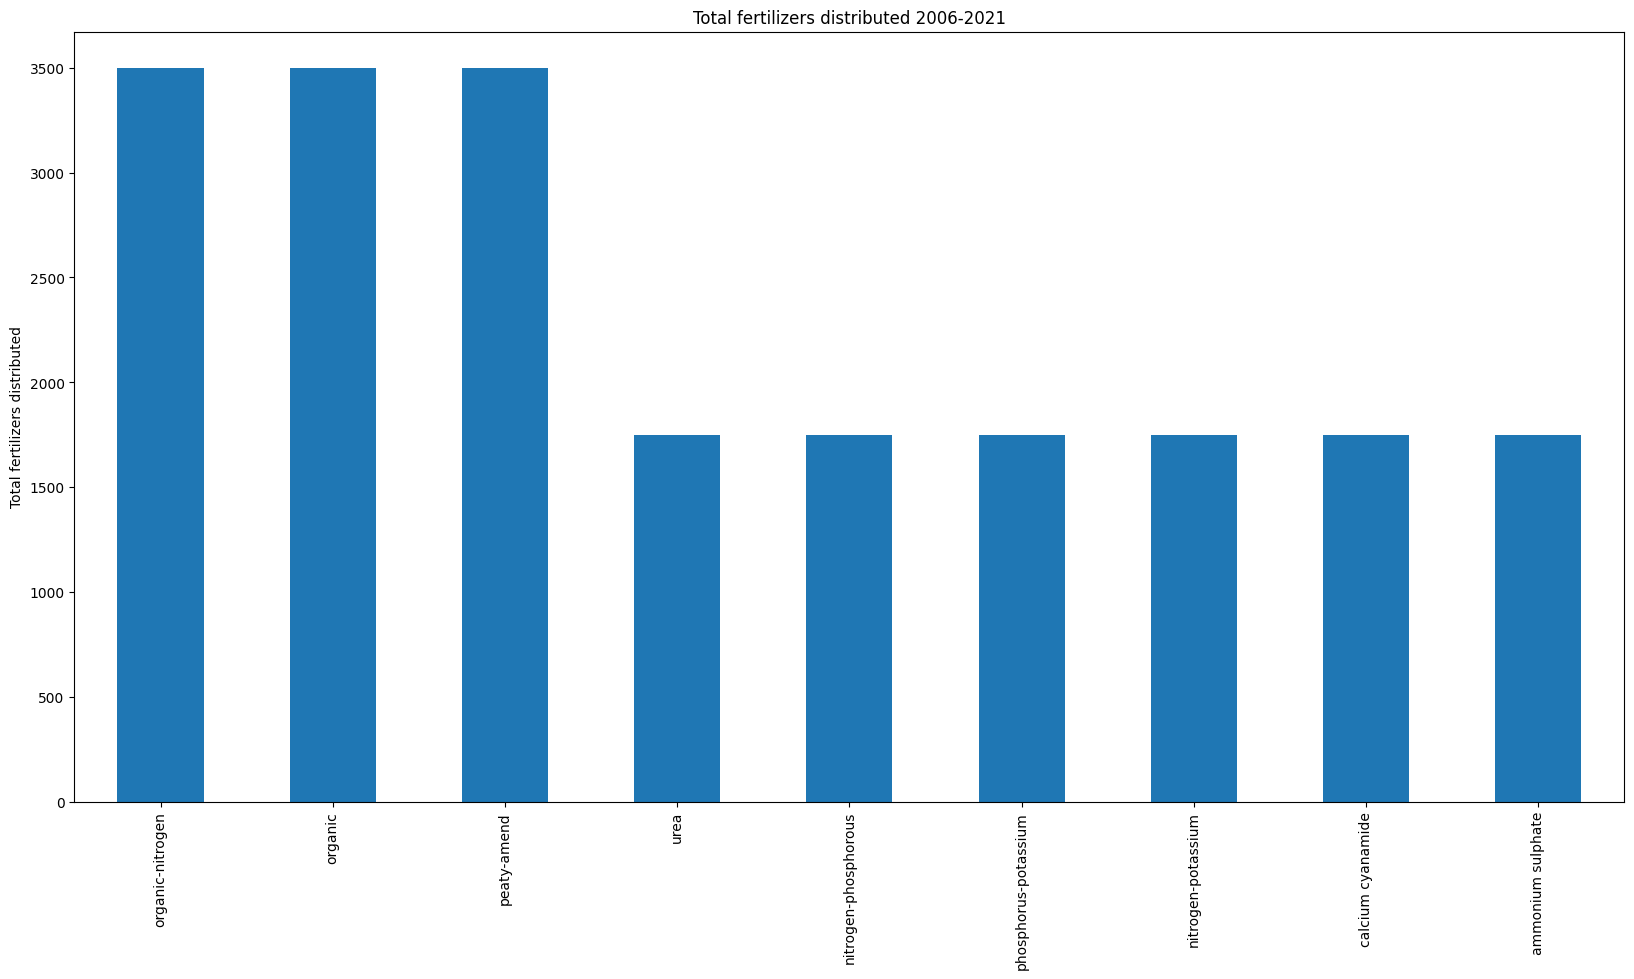

In [50]:

plt.figure(figsize=(20,10))
fertilizer['Type_fertilizer'].value_counts().plot.bar()
plt.title('Total fertilizers distributed 2006-2021')
plt.ylabel('Total fertilizers distributed')
plt.show()


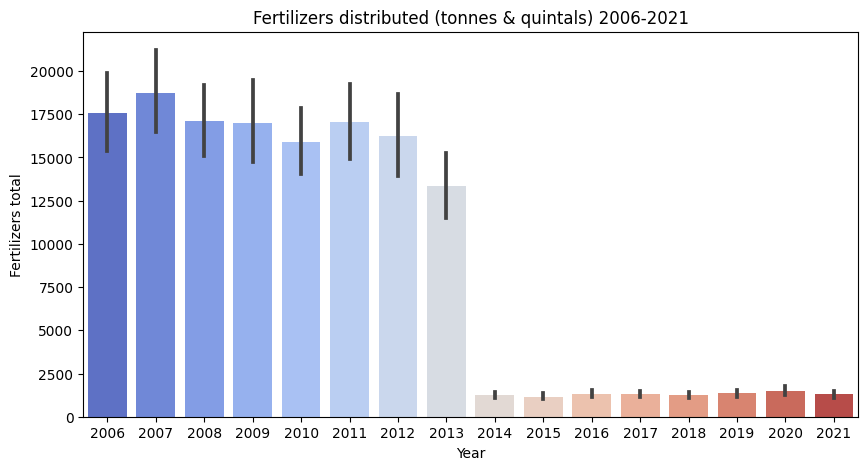

In [51]:
# fertilizer distributed tonnes and quintals
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'Fertilizers_tonnes',data = fertilizer, palette='coolwarm')
plt.title('Fertilizers distributed (tonnes & quintals) 2006-2021')
plt.xlabel('Year')
plt.ylabel('Fertilizers total')
plt.show()


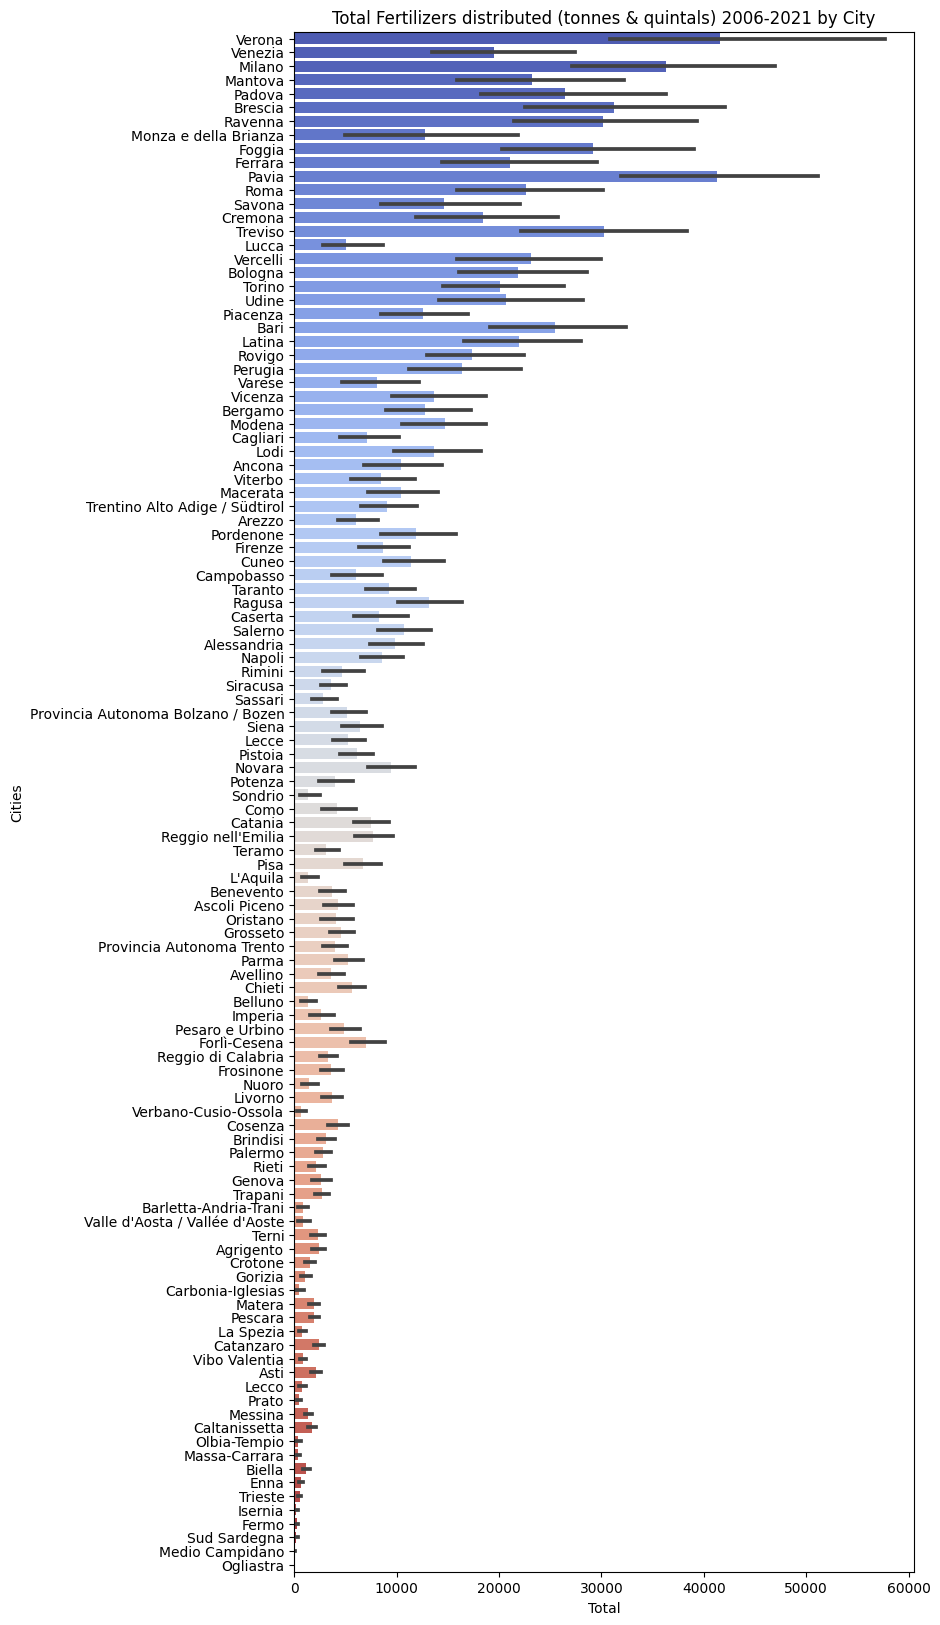

In [52]:
fertilizer= fertilizer.sort_values('Fertilizers_tonnes',ascending=False)

plt.figure(figsize= (8,20))
sns.barplot(x=fertilizer['Fertilizers_tonnes'] ,y= fertilizer ['City'], palette='coolwarm');
plt.title('Total Fertilizers distributed (tonnes & quintals) 2006-2021 by City')
plt.xlabel('Total')
plt.ylabel('Cities')
plt.show()

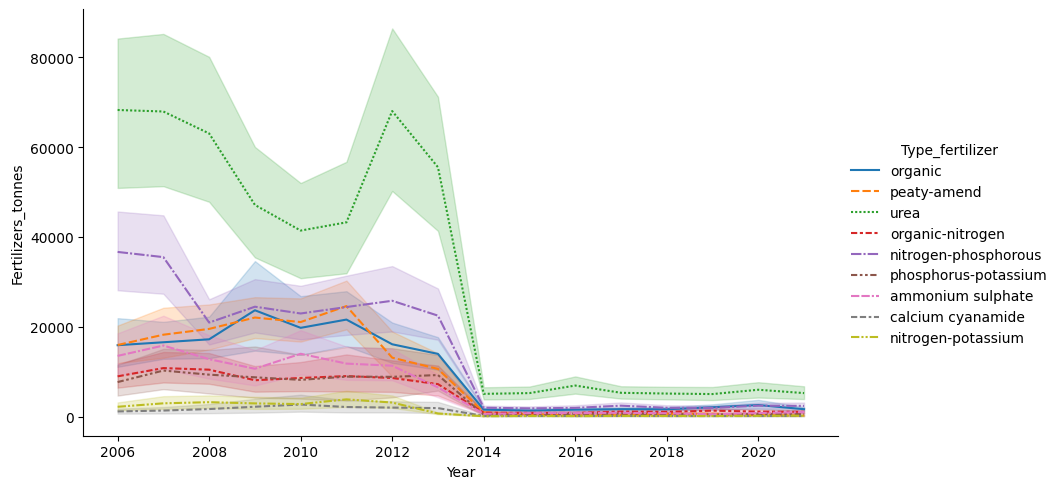

In [53]:
#Fertilizers distributed by year

fertilizer_plot = sns.relplot(kind='line', data=fertilizer, x='Year', y='Fertilizers_tonnes', hue='Type_fertilizer', style='Type_fertilizer', aspect=1.75)


In [54]:
fertilizer.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
8734,Verona,organic,2009,986716
9983,Venezia,organic,2010,500556
5532,Milano,peaty-amend,2007,460504
7390,Mantova,organic,2009,453752
8731,Verona,organic,2006,392359


#### Create new dataframe with the selected type of fertilizers as columns  

In [55]:
# Create columns for each type of fertilizer 
fertilizer_pivot = fertilizer.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer_pivot

Fertilizers_tonnes                                         \
Type_fertilizer  ammonium sulphate calcium cyanamide nitrogen-phosphorous   
City      Year                                                              
Agrigento 2006             1687.00              0.00              4977.00   
          2007             2171.00              0.00              6498.00   
          2008             1400.00              0.00              5213.00   
          2009             1404.00              0.00              3808.00   
          2010             1416.00            140.00              3271.00   
...                            ...               ...                  ...   
Viterbo   2017              153.00              0.00              4732.00   
          2018              149.00              0.00              4376.00   
          2019               70.00              0.00              3964.00   
          2020              176.00              0.00              6145.00   
          2021              152.00              0.00              3946.00   

                                                                          \
Type_fertilizer nitrogen-potassium  organic organic-nitrogen peaty-amend   
City      Year                                                             
Agrigento 2006              277.00 31439.00          7779.00     2966.00   
          2007              491.00 35348.00          6079.00     2949.00   
          2008              614.00 37504.00         14075.00     3506.00   
          2009              468.00 27914.00          8984.00     5678.00   
          2010              440.00 23460.00          9136.00     3082.00   
...                            ...      ...              ...         ...   
Viterbo   2017               66.00  1760.00          2268.00      274.00   
          2018               19.00  1591.00          2106.00      811.00   
          2019              195.00  1251.00          2884.00      427.00   
          2020               98.00  1236.00          2935.00      275.00   
          2021              112.00  1056.00          3337.00      131.00   

                                              
Type_fertilizer phosphorus-potassium    urea  
City      Year                                
Agrigento 2006               2093.00 2100.00  
          2007               2953.00 5100.00  
          2008               4438.00 2736.00  
          2009               3590.00 2716.00  
          2010               3506.00 2962.00  
...                              ...     ...  
Viterbo   2017                179.00 2859.00  
          2018                 91.00 2863.00  
          2019                 95.00 2413.00  
          2020                119.00 3578.00  
          2021                126.00 2054.00  

[1749 rows x 9 columns]

In [56]:
# Drop level
fertilizer_pivot.columns = fertilizer_pivot.columns.droplevel()
fertilizer_pivot

Type_fertilizer  ammonium sulphate  calcium cyanamide  nitrogen-phosphorous  \
City      Year                                                                
Agrigento 2006             1687.00               0.00               4977.00   
          2007             2171.00               0.00               6498.00   
          2008             1400.00               0.00               5213.00   
          2009             1404.00               0.00               3808.00   
          2010             1416.00             140.00               3271.00   
...                            ...                ...                   ...   
Viterbo   2017              153.00               0.00               4732.00   
          2018              149.00               0.00               4376.00   
          2019               70.00               0.00               3964.00   
          2020              176.00               0.00               6145.00   
          2021              152.00               0.00               3946.00   

Type_fertilizer  nitrogen-potassium  organic  organic-nitrogen  peaty-amend  \
City      Year                                                                
Agrigento 2006               277.00 31439.00           7779.00      2966.00   
          2007               491.00 35348.00           6079.00      2949.00   
          2008               614.00 37504.00          14075.00      3506.00   
          2009               468.00 27914.00           8984.00      5678.00   
          2010               440.00 23460.00           9136.00      3082.00   
...                             ...      ...               ...          ...   
Viterbo   2017                66.00  1760.00           2268.00       274.00   
          2018                19.00  1591.00           2106.00       811.00   
          2019               195.00  1251.00           2884.00       427.00   
          2020                98.00  1236.00           2935.00       275.00   
          2021               112.00  1056.00           3337.00       131.00   

Type_fertilizer  phosphorus-potassium    urea  
City      Year                                 
Agrigento 2006                2093.00 2100.00  
          2007                2953.00 5100.00  
          2008                4438.00 2736.00  
          2009                3590.00 2716.00  
          2010                3506.00 2962.00  
...                               ...     ...  
Viterbo   2017                 179.00 2859.00  
          2018                  91.00 2863.00  
          2019                  95.00 2413.00  
          2020                 119.00 3578.00  
          2021                 126.00 2054.00  

[1749 rows x 9 columns]

In [57]:
#Rename index
fertilizer_pivot = fertilizer_pivot.rename_axis(None,axis=1)
fertilizer_pivot

ammonium sulphate  calcium cyanamide  nitrogen-phosphorous  \
City      Year                                                               
Agrigento 2006            1687.00               0.00               4977.00   
          2007            2171.00               0.00               6498.00   
          2008            1400.00               0.00               5213.00   
          2009            1404.00               0.00               3808.00   
          2010            1416.00             140.00               3271.00   
...                           ...                ...                   ...   
Viterbo   2017             153.00               0.00               4732.00   
          2018             149.00               0.00               4376.00   
          2019              70.00               0.00               3964.00   
          2020             176.00               0.00               6145.00   
          2021             152.00               0.00               3946.00   

                nitrogen-potassium  organic  organic-nitrogen  peaty-amend  \
City      Year                                                               
Agrigento 2006              277.00 31439.00           7779.00      2966.00   
          2007              491.00 35348.00           6079.00      2949.00   
          2008              614.00 37504.00          14075.00      3506.00   
          2009              468.00 27914.00           8984.00      5678.00   
          2010              440.00 23460.00           9136.00      3082.00   
...                            ...      ...               ...          ...   
Viterbo   2017               66.00  1760.00           2268.00       274.00   
          2018               19.00  1591.00           2106.00       811.00   
          2019              195.00  1251.00           2884.00       427.00   
          2020               98.00  1236.00           2935.00       275.00   
          2021              112.00  1056.00           3337.00       131.00   

                phosphorus-potassium    urea  
City      Year                                
Agrigento 2006               2093.00 2100.00  
          2007               2953.00 5100.00  
          2008               4438.00 2736.00  
          2009               3590.00 2716.00  
          2010               3506.00 2962.00  
...                              ...     ...  
Viterbo   2017                179.00 2859.00  
          2018                 91.00 2863.00  
          2019                 95.00 2413.00  
          2020                119.00 3578.00  
          2021                126.00 2054.00  

[1749 rows x 9 columns]

In [58]:
# Reset index
fertilizer_pivot = fertilizer_pivot.reset_index()
fertilizer_pivot

,City,Year,ammonium sulphate,calcium cyanamide,nitrogen-phosphorous,nitrogen-potassium,organic,organic-nitrogen,peaty-amend,phosphorus-potassium,urea
0,Agrigento,2006,1687.00,0.00,4977.00,277.00,31439.00,7779.00,2966.00,2093.00,2100.00
1,Agrigento,2007,2171.00,0.00,6498.00,491.00,35348.00,6079.00,2949.00,2953.00,5100.00
2,Agrigento,2008,1400.00,0.00,5213.00,614.00,37504.00,14075.00,3506.00,4438.00,2736.00
3,Agrigento,2009,1404.00,0.00,3808.00,468.00,27914.00,8984.00,5678.00,3590.00,2716.00
4,Agrigento,2010,1416.00,140.00,3271.00,440.00,23460.00,9136.00,3082.00,3506.00,2962.00
...,...,...,...,...,...,...,...,...,...,...,...
1744,Viterbo,2017,153.00,0.00,4732.00,66.00,1760.00,2268.00,274.00,179.00,2859.00
1745,Viterbo,2018,149.00,0.00,4376.00,19.00,1591.00,2106.00,811.00,91.00,2863.00
1746,Viterbo,2019,70.00,0.00,3964.00,195.00,1251.00,2884.00,427.00,95.00,2413.00
1747,Viterbo,2020,176.00,0.00,6145.00,98.00,1236.00,2935.00,275.00,119.00,3578.00


#### Join crop and fertilizers datasets 

In [59]:
# Join both datasets 
it_crop_ferlizer = pd.merge(cereals_top10_pivot, fertilizer_pivot, on=['Year', 'City'], how='left').fillna(0)
it_crop_ferlizer

,City,Year,barley,bro-bean,c-wheat,chick-peas,d-wheat,dry-k-bean,maize,oats,...,rye,ammonium sulphate,calcium cyanamide,nitrogen-phosphorous,nitrogen-potassium,organic,organic-nitrogen,peaty-amend,phosphorus-potassium,urea
0,Agrigento,2006,8970.00,70490.00,0.00,1500.00,1102000.00,800.00,0.00,7260.00,...,0.00,1687.00,0.00,4977.00,277.00,31439.00,7779.00,2966.00,2093.00,2100.00
1,Agrigento,2007,8400.00,66774.00,0.00,1395.00,1180000.00,671.00,0.00,7537.00,...,0.00,2171.00,0.00,6498.00,491.00,35348.00,6079.00,2949.00,2953.00,5100.00
2,Agrigento,2008,9250.00,74400.00,0.00,1207.00,1218000.00,630.00,0.00,8160.00,...,0.00,1400.00,0.00,5213.00,614.00,37504.00,14075.00,3506.00,4438.00,2736.00
3,Agrigento,2009,10400.00,70400.00,0.00,1233.00,953846.00,650.00,0.00,9460.00,...,0.00,1404.00,0.00,3808.00,468.00,27914.00,8984.00,5678.00,3590.00,2716.00
4,Agrigento,2010,11870.00,71230.00,0.00,1280.00,1347000.00,705.00,0.00,10700.00,...,0.00,1416.00,140.00,3271.00,440.00,23460.00,9136.00,3082.00,3506.00,2962.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1844,Viterbo,2018,430000.00,0.00,117600.00,11200.00,768000.00,660.00,198000.00,26500.00,...,5040.00,149.00,0.00,4376.00,19.00,1591.00,2106.00,811.00,91.00,2863.00
1845,Viterbo,2019,510000.00,0.00,140000.00,10500.00,800000.00,600.00,180000.00,33600.00,...,5600.00,70.00,0.00,3964.00,195.00,1251.00,2884.00,427.00,95.00,2413.00
1846,Viterbo,2020,555000.00,0.00,136000.00,10100.00,749000.00,590.00,178000.00,31100.00,...,5100.00,176.00,0.00,6145.00,98.00,1236.00,2935.00,275.00,119.00,3578.00
1847,Viterbo,2021,540000.00,0.00,129000.00,9850.00,740000.00,340.00,172500.00,30100.00,...,4790.00,152.00,0.00,3946.00,112.00,1056.00,3337.00,131.00,126.00,2054.00


### Correlation analysis


In [60]:

crop = it_crop_ferlizer.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer['target']=crop.cat.codes

cor_selected = it_crop_ferlizer[['barley','oats','d-wheat','c-wheat', 'maize',
                                 'potatoes','dry-k-bean','bro-bean','chick-peas',
                                 'rye','calcium cyanamide','nitrogen-potassium','organic',
                                 'phosphorus-potassium','urea']]


<AxesSubplot: title={'center': 'Correlation'}>

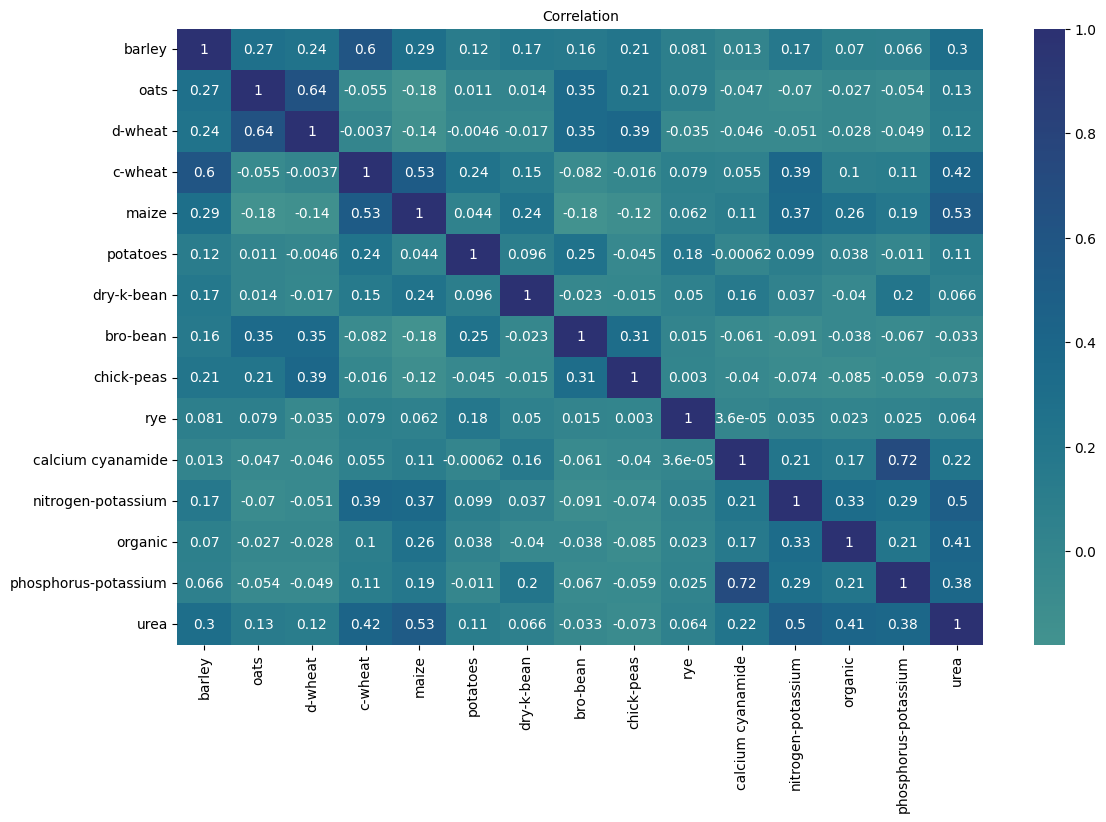

In [61]:
plt.figure(figsize=(13,8))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of cereal and legumes production in Italy : 

* Maize has hight correlation with common Wheat and correlation with urea.

* Barley has hight correlation with Wheat.

* Oats has hight correlation with Durum Wheat. 

* Rice has hight correlation with phosphorus-potassium. 

* There is also hight correlation between urea, nitrogen-potassium, calcium and phosphorus-potassium fertilizers.


### Calculating Variance Inflation Factor (VIF) for all given features



In [62]:
# Function to compute the VIF
def compute_vif(selected_features):
    
    y = cor_selected [selected_features]
    # the calculation of variance inflation requires a constant
    y['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Feature"] = y.columns
    vif["VIF"] = [variance_inflation_factor(y.values, i) for i in range(y.shape[1])]
    vif = vif[vif['Feature']!='intercept']
    return vif

In [63]:
# Features selection
selected_features = ['barley','oats','d-wheat','c-wheat', 'maize',
                                 'potatoes','dry-k-bean','bro-bean','chick-peas',
                                 'rye','calcium cyanamide','nitrogen-potassium','organic',
                                 'phosphorus-potassium','urea']

# compute vif 
compute_vif(selected_features).sort_values('VIF', ascending=False)


,Feature,VIF
3,c-wheat,2.41
13,phosphorus-potassium,2.41
14,urea,2.24
10,calcium cyanamide,2.09
1,oats,2.03
2,d-wheat,2.00
0,barley,1.99
4,maize,1.98
11,nitrogen-potassium,1.51
7,bro-bean,1.40


We have performed variance inflation factor (VIF) to detect if there is multicollinearity. Some references indicates a serious collinearity problem if VIF greater or equal to 5. 

In this analys none of the features have VIF higher than 5.  
 

Modelling*

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html

https://www.statisticshowto.com/variance-inflation-factor/

https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/